In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


# Import data

In [31]:
# gdpnow = pd.read_csv('test_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# # Ensure that load_df index is in the same date format
# gdpnow.index = pd.to_datetime(gdpnow.index)

## Let's define X and y

In [38]:
#Target S&P
Target = 'SPX Index '
Drop = ['Quarter being forecasted', 'Advance Estimate From BEA',
        'Publication Date of Advance Estimate','Days until advance estimate', 'Forecast Error', 'Data releases', 'NDX Index ', 'SPX Index ']

# # Target USDJPY
# Target = 'USDJPY Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USDJPY Curncy']

# # Target 2y Interest Rates
# Target = 'USOSFR2 Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USOSFR2 Curncy', 'USOSFR10 Curncy']

# # Target WTI Oil
# Target = 'CL1 Comdty'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'CL1 Comdty']

# #Target GDP
# Target = 'Final_GDP_Interp'
# Drop = ['GDP Nowcast', 'Final_GDP_Interp', 'Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#       'Days until advance estimate', 'Forecast Error', 'Data releases']

# Load Train and Test

# Defining X and y

We now need the X and Y from the whole train and predict set that includes btm_gdp

In [39]:
# Splitting into test and train sets

train = pd.read_csv('train_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
X_train = train.drop(columns=Drop)
y_train = train[Target]

test = pd.read_csv('predict_set_w_btm.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
X_test = test.drop(columns=Drop)
y_test = test[Target]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3551, 66) (3551,)
(63, 66) (63,)


In [40]:
# Concatenate features (adding X_test to the bottom of X_train)
X = pd.concat([X_train, X_test])
# Concatenate labels (adding y_test to the bottom of y_train)
y = pd.concat([y_train, y_test])

print(X.shape, y.shape)


(3614, 66) (3614,)


### Optuna with Preproc

In [41]:


# Assuming X_dropped and y_dropped are your dataset

def objective(trial):
    # Suggest values for the preprocessing parameters
    n_neighbors = trial.suggest_int('n_neighbors', 1, 3)
    percentile = trial.suggest_int('percentile', 40, 80)

    # Create the preprocessing pipeline with suggested parameters
    preproc = Pipeline([
        ('imputer', KNNImputer(n_neighbors=n_neighbors)),
        ('scaler', RobustScaler()),
        ('feature_selection', SelectPercentile(mutual_info_regression, percentile=percentile))
    ])

    X_preproc_train = preproc.fit_transform(X_train, y_train)

    # Suggest values for the model's hyperparameters
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.15, 0.25),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
    }

    # Initialize and train the XGBoost regressor
    model = xgb.XGBRegressor(**params)
    model.fit(X_preproc_train, y_train)

    # Make predictions on the processed test set
    X_preproc_test = preproc.transform(X_test)
    preds = model.predict(X_preproc_test)

    # Evaluate the model using negative mean absolute error
    neg_mae = -mean_absolute_error(y_test, preds)

    return neg_mae  # Optimize for neg_MAE

# Create and execute the Optuna study
study = optuna.create_study(direction='maximize')  # We are minimizing the negative MAE
study.optimize(objective, n_trials=500)  # Adjust n_trials based on computational budget

# Print best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value (neg_MAE): {trial.value:.4f}")
for key, value in trial.params.items():
    print(f" {key}: {value}")


[I 2024-03-25 14:10:51,756] A new study created in memory with name: no-name-72931373-c375-451e-935e-f1918ff262e6


[I 2024-03-25 14:10:54,858] Trial 0 finished with value: -337.49429346478183 and parameters: {'n_neighbors': 1, 'percentile': 42, 'max_depth': 24, 'learning_rate': 0.20722909286589025, 'n_estimators': 121, 'min_child_weight': 4, 'gamma': 0.6615221314736822, 'subsample': 0.7229420149806611, 'colsample_bytree': 0.7110786686947865, 'reg_alpha': 0.29511816914765776, 'reg_lambda': 7.43262306194372}. Best is trial 0 with value: -337.49429346478183.
[I 2024-03-25 14:11:01,200] Trial 1 finished with value: -488.19025111607147 and parameters: {'n_neighbors': 2, 'percentile': 53, 'max_depth': 32, 'learning_rate': 0.2302904300809795, 'n_estimators': 662, 'min_child_weight': 10, 'gamma': 0.014983033980063731, 'subsample': 0.9185520246315091, 'colsample_bytree': 0.962577541203148, 'reg_alpha': 0.7654255365348314, 'reg_lambda': 5.3375236731593025}. Best is trial 0 with value: -337.49429346478183.
[I 2024-03-25 14:11:05,869] Trial 2 finished with value: -360.6459880332342 and parameters: {'n_neighbor

Best trial:
 Value (neg_MAE): -208.2186
 n_neighbors: 2
 percentile: 51
 max_depth: 6
 learning_rate: 0.1733868377666836
 n_estimators: 1061
 min_child_weight: 8
 gamma: 0.7558719633372508
 subsample: 0.627265097733885
 colsample_bytree: 0.8022560912972065
 reg_alpha: 0.561887153195709
 reg_lambda: 6.628481815595045


# Pipeline

In [ ]:
# preproc = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', RobustScaler())
# ])

# preproc_selector = Pipeline([
#     ('preprocessing', preproc),  # Include the preprocessing steps with PCA
#     ('feature_selection', SelectPercentile(
#         mutual_info_regression))
# ])

# Modeling

In [ ]:
""" #Modeling with initial dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [10, 15, 20],
    'model__reg_alpha': [0, 0.1, 1.0],  # L1 regularization parameter (alpha)
    'model__reg_lambda': [0, 0.1, 1.0],
    'preprocessor__feature_selection__percentile' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]# L2 regularization parameter (lambda)

}

pipe = Pipeline([
     ('preprocessor', preproc_selector),
     ('model', model)
 ])

random_search = RandomizedSearchCV(
     pipe,
     param_distributions=param_distributions,
     n_iter=10,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
     cv=5,
     verbose=2,
     #random_state=42,
     n_jobs=-1  # Use all available cores
 )

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_) """

' #Modeling with initial dataset\n\nmodel = XGBRegressor(random_state=42)\n\nparam_distributions = {\n    \'model__n_estimators\': [100, 200, 300],\n    \'model__learning_rate\': [0.01, 0.1, 0.2],\n    \'model__max_depth\': [10, 15, 20],\n    \'model__reg_alpha\': [0, 0.1, 1.0],  # L1 regularization parameter (alpha)\n    \'model__reg_lambda\': [0, 0.1, 1.0],\n    \'preprocessor__feature_selection__percentile\' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]# L2 regularization parameter (lambda)\n\n}\n\npipe = Pipeline([\n     (\'preprocessor\', preproc_selector),\n     (\'model\', model)\n ])\n\nrandom_search = RandomizedSearchCV(\n     pipe,\n     param_distributions=param_distributions,\n     n_iter=10,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.\n     scoring=\'neg_mean_absolute_error\',  # Assuming MSE is the metric of interest; adjust as needed.\n     cv=5,\n     verbose=2,\n     #random_state=42,\n     n_jobs=-1  # Use all 

In [ ]:
random_search.score(X_test, y_test)

NameError: name 'random_search' is not defined

In [ ]:
y_pred = random_search.predict(X_test)

# Best Parameters

In [42]:
trial.params

{'n_neighbors': 2,
 'percentile': 51,
 'max_depth': 6,
 'learning_rate': 0.1733868377666836,
 'n_estimators': 1061,
 'min_child_weight': 8,
 'gamma': 0.7558719633372508,
 'subsample': 0.627265097733885,
 'colsample_bytree': 0.8022560912972065,
 'reg_alpha': 0.561887153195709,
 'reg_lambda': 6.628481815595045}

# Fitting best model 

In [43]:

# # Extract best parameters for preprocessing and model
# best_params = study.best_trial.params

# S&P Best Params
best_params =  {'n_neighbors': 2,
 'percentile': 51,
 'max_depth': 6,
 'learning_rate': 0.1733868377666836,
 'n_estimators': 1061,
 'min_child_weight': 8,
 'gamma': 0.7558719633372508,
 'subsample': 0.627265097733885,
 'colsample_bytree': 0.8022560912972065,
 'reg_alpha': 0.561887153195709,
 'reg_lambda': 6.628481815595045}


# # IRS
# best_params = {'n_neighbors': 3,
#  'percentile': 51,
#  'max_depth': 18,
#  'learning_rate': 0.20942459081976394,
#  'n_estimators': 835,
#  'min_child_weight': 4,
#  'gamma': 0.5896969019019073,
#  'subsample': 0.9257108822918529,
#  'colsample_bytree': 0.941416612869769,
#  'reg_alpha': 0.29967633514259356,
#  'reg_lambda': 8.432105613686591}


# GDP
# best_params = {
#     'n_neighbors': 3,
#     'percentile': 49,
#     'max_depth': 9,
#     'learning_rate': 0.2498773755675101,
#     'n_estimators': 1099,
#     'min_child_weight': 5,
#     'gamma': 4.948772788547994e-05,
#     'subsample': 0.8451156656189625,
#     'colsample_bytree': 0.6148165960748299,
#     'reg_alpha': 0.3365824497976371,
#     'reg_lambda': 3.450245765937823
# }


# Create the optimal preprocessing pipeline
preproc_optimal = Pipeline([
    ('imputer', KNNImputer(n_neighbors=best_params['n_neighbors'])),
    ('scaler', RobustScaler()),
    ('feature_selection', SelectPercentile(mutual_info_regression, percentile=best_params['percentile']))
])

# Create the model with optimal parameters
model_optimal = xgb.XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda']
)

# # Combine into a single pipeline
# pipe_optimal = Pipeline([
#     ('preprocessing', preproc_optimal),
#     ('model', model_optimal)
# ])


In [44]:
# Combine into a single pipeline
pipe_best = Pipeline([
    ('preprocessing', preproc_optimal),
    ('model', model_optimal)
])

# Fit the optimal pipeline to the full set
pipe_best.fit(X, y)

# Assuming X_train and y_train are already defined and contain your training data
score = cross_val_score(pipe_best, X, y, cv=5, scoring='neg_mean_absolute_error')


# Printing the standard deviation and mean of the cross-validation scores
print(score.std())
print(score.mean())

68.72237697204277
-282.06463465855234


# Predictions on X_test

In [45]:
y_pred = pipe_best.predict(X_test)

In [46]:
y_pred = pd.Series(y_pred).reset_index(drop = True)

In [48]:
y_pred.index = y_test.index
df_plot = pd.DataFrame()
df_plot = pd.concat([y_test, y_pred], axis=1)


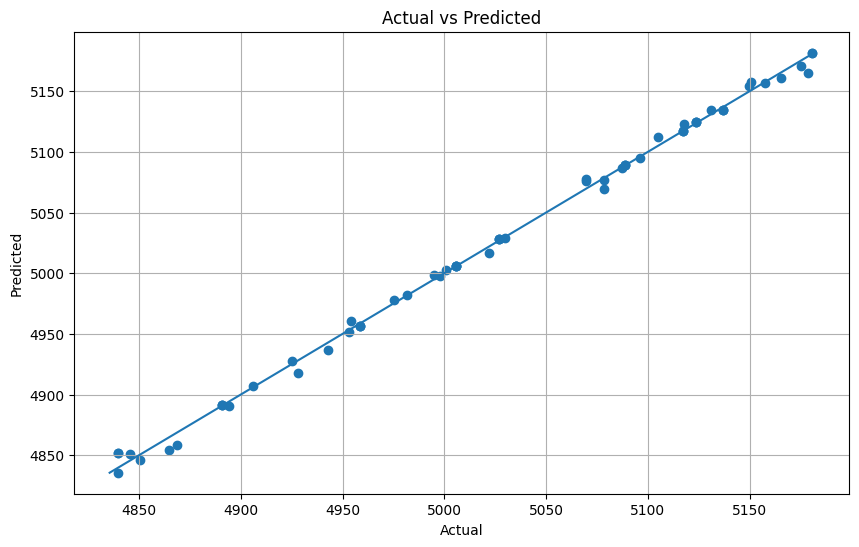

In [49]:
# Compute dynamic min and max for the line
min_val = min(df_plot[Target].min(), df_plot[0].min())
max_val = max(df_plot[Target].max(), df_plot[0].max())

# Adjust a and b dynamically
a = [min_val, max_val]
b = [min_val, max_val]

plt.figure(figsize=(10, 6))
plt.plot(a,b)
scatter = plt.scatter(df_plot[Target], df_plot[0] )
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Loss curves

[0]	validation_0-mae:570.57760	validation_1-mae:1633.35198
[1]	validation_0-mae:413.75630	validation_1-mae:1389.02829
[2]	validation_0-mae:300.05203	validation_1-mae:1212.65733
[3]	validation_0-mae:217.61142	validation_1-mae:1078.63791
[4]	validation_0-mae:157.85114	validation_1-mae:982.38292
[5]	validation_0-mae:114.49839	validation_1-mae:907.84284
[6]	validation_0-mae:83.07464	validation_1-mae:856.51302
[7]	validation_0-mae:60.33218	validation_1-mae:827.74961
[8]	validation_0-mae:43.82712	validation_1-mae:789.95876
[9]	validation_0-mae:31.89461	validation_1-mae:766.30897
[10]	validation_0-mae:23.28698	validation_1-mae:745.94062
[11]	validation_0-mae:17.11971	validation_1-mae:732.84931
[12]	validation_0-mae:12.72556	validation_1-mae:718.51889
[13]	validation_0-mae:9.59034	validation_1-mae:706.80410
[14]	validation_0-mae:7.41941	validation_1-mae:703.75608
[15]	validation_0-mae:5.93489	validation_1-mae:700.81858
[16]	validation_0-mae:4.95903	validation_1-mae:694.42254
[17]	validation_0-

/Users/thomasbowden/.pyenv/versions/lewagon/envs/project-btm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-mae:2.19561	validation_1-mae:676.61031
[31]	validation_0-mae:2.15363	validation_1-mae:675.90163
[32]	validation_0-mae:2.10624	validation_1-mae:674.92301
[33]	validation_0-mae:2.06379	validation_1-mae:674.92666
[34]	validation_0-mae:2.03913	validation_1-mae:674.53813
[35]	validation_0-mae:2.00601	validation_1-mae:674.53996
[36]	validation_0-mae:1.93667	validation_1-mae:674.86449
[37]	validation_0-mae:1.88998	validation_1-mae:674.86632
[38]	validation_0-mae:1.82778	validation_1-mae:674.85946
[39]	validation_0-mae:1.79624	validation_1-mae:674.86175
[40]	validation_0-mae:1.77716	validation_1-mae:674.86312
[41]	validation_0-mae:1.74988	validation_1-mae:674.70785
[42]	validation_0-mae:1.70854	validation_1-mae:674.87183
[43]	validation_0-mae:1.67795	validation_1-mae:674.96308
[44]	validation_0-mae:1.65773	validation_1-mae:674.65672
[45]	validation_0-mae:1.62292	validation_1-mae:674.65672
[46]	validation_0-mae:1.59247	validation_1-mae:674.65763
[47]	validation_0-mae:1.57507	v

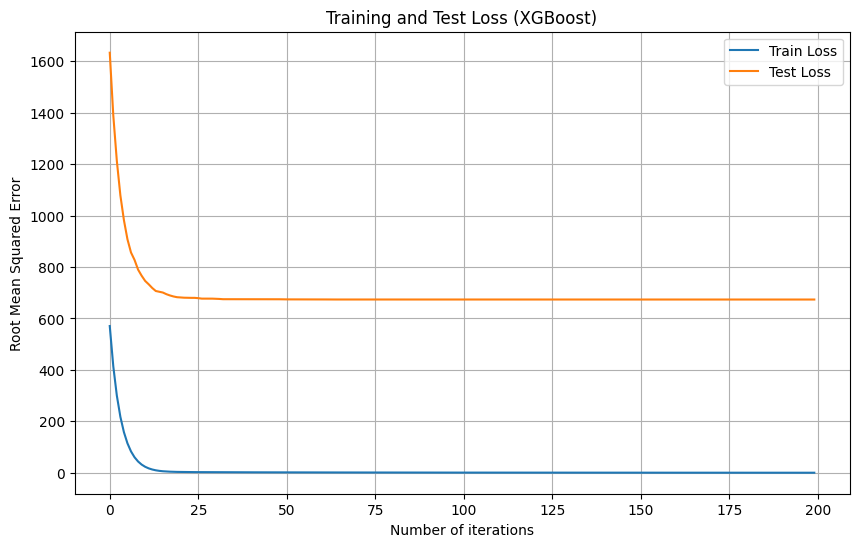

In [50]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have your X_train, y_train, X_test, and y_test data prepared

# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=200, max_depth = 9, learning_rate = 0.275, random_state=42, reg_lambda = 0.01)

X_train_preproc = preproc_optimal.fit_transform(X_train, y_train)
X_test_preproc = preproc_optimal.transform(X_test)

# Fit the model with evaluation set
eval_set = [(X_train_preproc, y_train), (X_test_preproc, y_test)]
xgb_regressor.fit(X_train_preproc, y_train, eval_set=eval_set, eval_metric="mae", verbose=True)

# Extract training and validation loss from the model's history
results = xgb_regressor.evals_result()
train_loss = results['validation_0']['mae']
test_loss = results['validation_1']['mae']

# Plot the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Test Loss (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Predictions on Unseen data (> 19/01/2024)

In [51]:
predict_data = pd.read_csv('predict_set_w_btm.csv', index_col='Dates', parse_dates=True)

predict_data.index = pd.to_datetime(predict_data.index)

unseen_X = predict_data.drop(columns=Drop)
unseen_y = predict_data[Target]

assert(unseen_X.shape[0]==unseen_y.shape[0])

In [52]:
predictions = pipe_best.predict(unseen_X)

predictions = pd.Series(predictions)
predictions.index = unseen_y.index

df_plot = pd.DataFrame()
df_plot = pd.concat([unseen_y, predictions], axis=1)
df_plot.columns

Index(['SPX Index ', 0], dtype='object')

In [ ]:
df_plot['Mkt'] = df_plot[df_plot.columns[0]]
df_plot['Mdl'] = df_plot[0]
df_plot['Diff'] = df_plot[df_plot.columns[0]] - df_plot[0]

df_plot = df_plot.drop(columns=[df_plot.columns[0], 0])


In [ ]:
df_plot

,Mkt,Mdl,Diff
Dates,,,
2024-01-19,4839.81,4880.433105,-40.623105
2024-01-20,4839.81,4897.287598,-57.477598
2024-01-21,4839.81,4897.287598,-57.477598
2024-01-22,4850.43,4904.005859,-53.575859
2024-01-23,4864.60,4896.910645,-32.310645
...,...,...,...
2024-03-17,5117.09,4973.674805,143.415195
2024-03-18,5149.42,5005.640625,143.779375
2024-03-19,5178.51,5008.434570,170.075430


In [53]:
from sklearn.metrics import mean_absolute_error

# Assuming you have y_test and y_pred
mae = mean_absolute_error(unseen_y, predictions)
mae

137.77450892857132

In [ ]:

# plt.figure(figsize=(10, 6))

# scatter = plt.scatter(df_plot[Target], df_plot[0] )
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.grid(True)
# plt.show()

## Shapley Feature Test

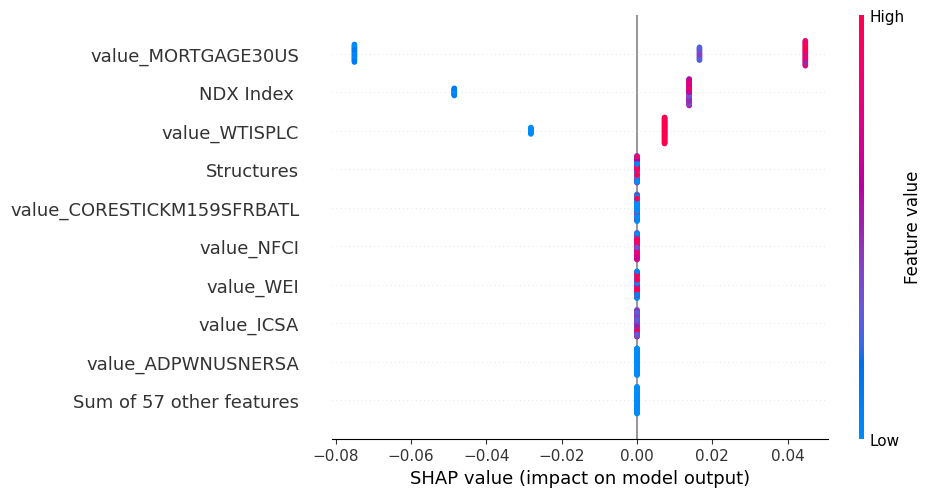

In [ ]:
# Feature Selection
import shap
# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)
# Compute SHAP values
shap_values = explainer(X_test)
# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.plots.beeswarm(shap_values)
#change

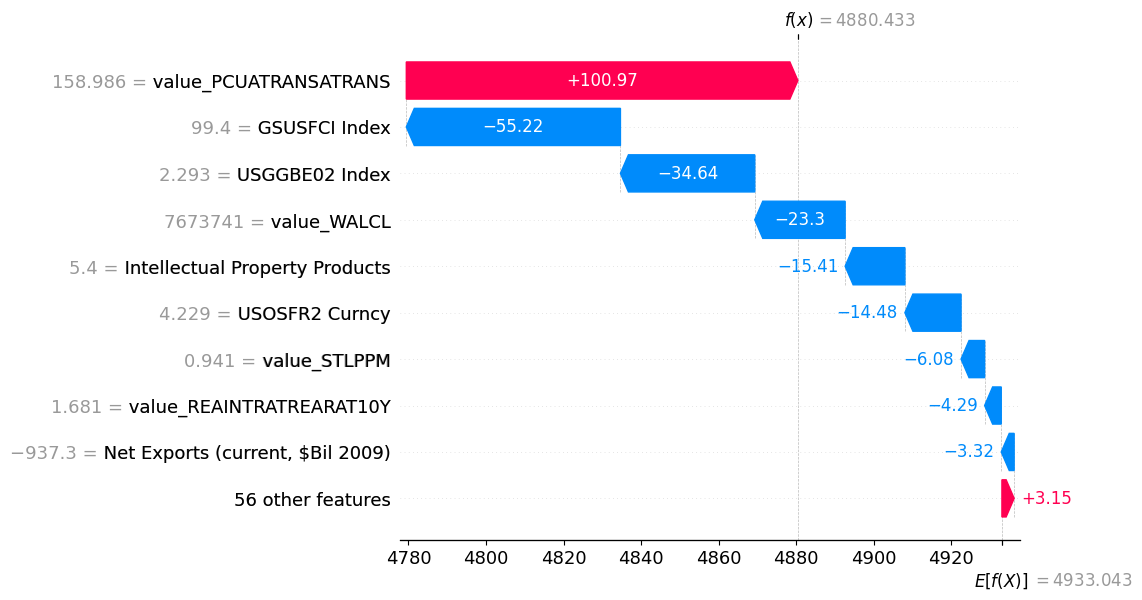

In [ ]:
# Feature Selection
import shap

# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)
# Compute SHAP values
shap_values = explainer(X_test)

# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.plots.waterfall(shap_values[0])
#change

In [ ]:
import csv
csv_file = 'best_params_SPX.csv'

# Define the fieldnames for the CSV file
fieldnames = ['Parameter', 'Value']

# Write the dictionary to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write each key-value pair as a row
    for key, value in best_params.items():
        writer.writerow({'Parameter': key, 'Value': value})

print(f"CSV file '{csv_file}' has been created.")

CSV file 'best_params_IRS.csv' has been created.


### Back Test A Strategy 

In [83]:
predictions_life = pipe_best.predict(X)
btm_gdp  = X['Final_GDP_Interp']

predictions_life = pd.Series(predictions_life)
predictions_life.index = y.index

df_plot_life = pd.DataFrame()
df_plot_life = pd.concat([y, predictions_life, btm_gdp], axis=1)


In [84]:
# Clean the df
df_plot_life['Market'] = df_plot_life[df_plot_life.columns[0]]
df_plot_life['BTM Model'] = df_plot_life[0]
df_plot_life['Diff'] = df_plot_life[df_plot_life.columns[0]] - df_plot_life[0]
df_plot_life['Diff Z-score'] = (df_plot_life['Diff'] - df_plot_life['Diff'].mean()) / df_plot_life['Diff'].std()
df_plot_life['BTM GDP'] = df_plot_life['Final_GDP_Interp'].fillna(method='ffill')
df_plot_life = df_plot_life.drop(columns=[df_plot_life.columns[0], 0, 'Final_GDP_Interp'])

df_plot_life.head(10)  # Displaying the first 10 rows for inspection


,Market,BTM Model,Diff,Diff Z-score,BTM GDP
Dates,,,,,
2014-05-01,1883.68,1902.226196,-18.546196,-0.167050,0.110000
2014-05-02,1881.14,1895.911255,-14.771255,-0.104119,0.152667
2014-05-03,1881.14,1895.911255,-14.771255,-0.104119,0.152667
2014-05-04,1881.14,1895.911255,-14.771255,-0.104119,0.152667
2014-05-05,1884.66,1900.315674,-15.655674,-0.118863,0.280667
2014-05-06,1867.72,1891.458252,-23.738252,-0.253606,0.323333
2014-05-07,1878.21,1896.537354,-18.327354,-0.163402,0.366000
2014-05-08,1875.63,1896.112427,-20.482427,-0.199329,0.408667
2014-05-09,1878.48,1893.327026,-14.847026,-0.105382,0.451333


In [86]:
df_plot_life.tail()

,Market,BTM Model,Diff,Diff Z-score,BTM GDP
Dates,,,,,
2024-03-17,5117.09,4922.594727,194.495273,3.384529,3.414106
2024-03-18,5149.42,4961.870605,187.549395,3.268735,3.414106
2024-03-19,5178.51,4963.522949,214.987051,3.726144,3.414106
2024-03-20,5180.40,4964.215332,216.184668,3.746109,3.414106
2024-03-21,5180.40,4964.215332,216.184668,3.746109,3.414106


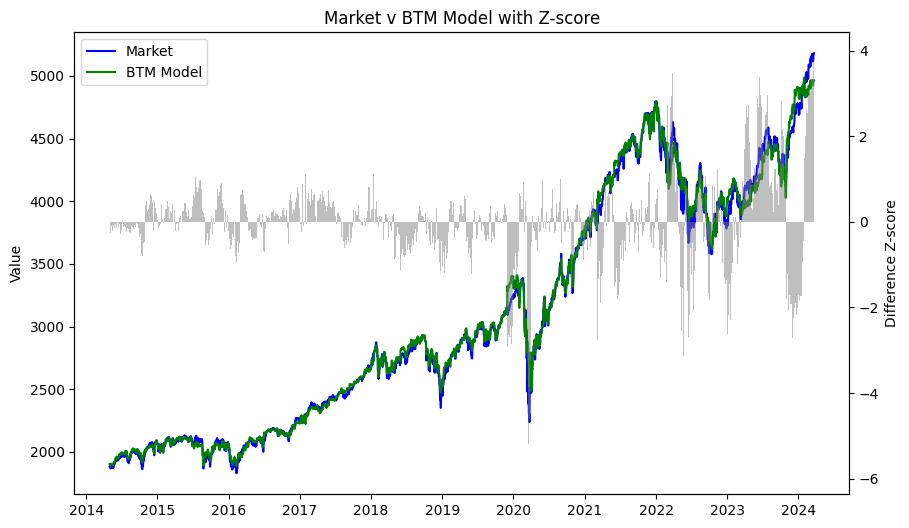

In [87]:
import matplotlib.pyplot as plt

# Creating a plot with two y-axes for the entire df_plot_life DataFrame
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line charts for 'Mkt' and 'Mdl'
ax1.plot(df_plot_life.index, df_plot_life['Market'], label='Market', color='blue')
ax1.plot(df_plot_life.index, df_plot_life['BTM Model'], label='BTM Model', color='green')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')

# Creating a twin axis for the 'Diff Z-score' bar chart
ax2 = ax1.twinx()
ax2.bar(df_plot_life.index, df_plot_life['Diff Z-score'], label='Diff Z', color='gray', alpha=0.5, width=1)
ax2.set_ylabel('Difference Z-score')
ax2.grid(False)

plt.title('Market v BTM Model with Z-score')
plt.show()


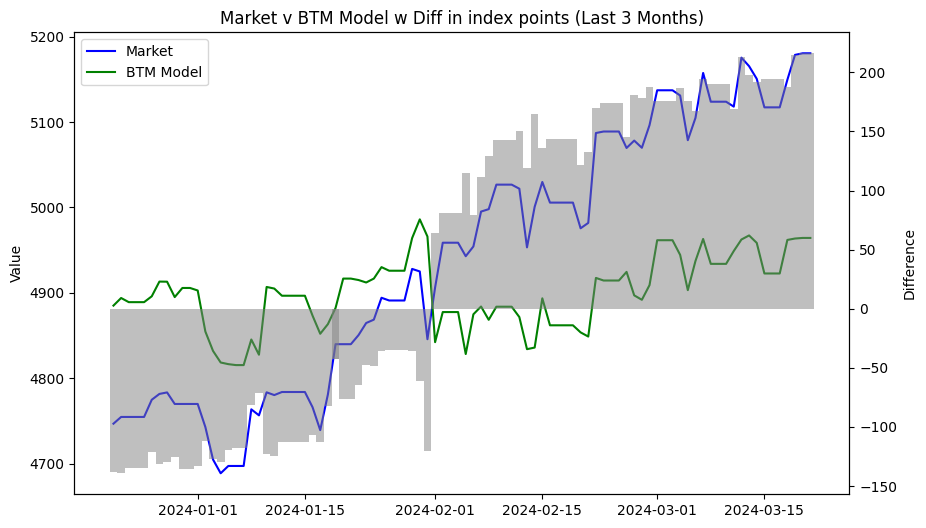

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_plot_life is already defined and has a DateTimeIndex
# Calculate the cutoff date for the last 3 months
cutoff_date = df_plot_life.index.max() - pd.DateOffset(months=3)

# Filter the DataFrame to include only the last 3 months
df_last_3_months = df_plot_life[df_plot_life.index >= cutoff_date]

# Creating a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line charts for 'Mkt' and 'Mdl' using the filtered DataFrame
ax1.plot(df_last_3_months.index, df_last_3_months['Market'], label='Market', color='blue')
ax1.plot(df_last_3_months.index, df_last_3_months['BTM Model'], label='BTM Model', color='green')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')

# Creating a twin axis for the 'Diff' bar chart
ax2 = ax1.twinx()
ax2.bar(df_last_3_months.index, df_last_3_months['Diff'], label='Diff', color='gray', alpha=0.5, width=1)
ax2.set_ylabel('Difference')
ax2.grid(False)

plt.title('Market v BTM Model w Diff in index points (Last 3 Months)')
plt.show()


In [80]:
import statsmodels.api as sm

# Perform Augmented Dickey-Fuller test
adf_result = sm.tsa.adfuller(df_plot_life['Diff'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -6.583571
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Based on the output of the Augmented Dickey-Fuller (ADF) test you've shared, here's the interpretation:

ADF Statistic: -7.400378. This is the calculated value of the test statistic.
p-value: 0.000000. This value indicates the probability of observing the test results under the null hypothesis. A low p-value (typically < 0.05) suggests that you can reject the null hypothesis.
Critical Values: These values are used to compare with the ADF statistic to determine the stationarity of the series at different confidence levels.
1%: -3.432
5%: -2.862
10%: -2.567
Given that the ADF statistic is significantly lower than the critical values at all common confidence levels (1%, 5%, and 10%), and the p-value is effectively 0, you can reject the null hypothesis that your series ('Diff' between the model prediction and the market values) has a unit root.

Conclusion: The 'Diff' series is stationary, suggesting that the differences between the model prediction and the market values do not follow a random walk and are mean-reverting. This implies that any deviations from the mean are temporary and the series will revert to its mean over time, which can be a useful property in various financial and econometric analyses.

In [ ]:
# Assuming df_plot_life is your DataFrame and already defined

# Strategy thresholds
threshold_T = 0.2  # Threshold to initiate a trade
threshold_L = 0.3  # Loss threshold
threshold_W = 0.1  # Win threshold

# Initializing the strategy column
df_plot_life['Strategy'] = None

for index in range(len(df_plot_life)):
    current_diff = df_plot_life.iloc[index]['Diff']  # Use 'Diff Z-score' if needed

    # Trade initiation condition
    if abs(current_diff) >= threshold_T:
        if index == 0 or pd.isnull(df_plot_life.iloc[index - 1]['Strategy']):
            df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'T'
        elif df_plot_life.iloc[index - 1]['Strategy'] == 'L':
            if abs(current_diff) >= threshold_L:
                df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'L'
            elif abs(current_diff) <= threshold_W:
                df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'W'
            continue

    # If trade is live
    if index > 0 and df_plot_life.iloc[index - 1]['Strategy'] in ['T', 'L']:
        df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'L'
        # Check for stop or take profit
        if abs(current_diff) >= threshold_L:
            df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'L'
        elif abs(current_diff) <= threshold_W:
            df_plot_life.at[df_plot_life.index[index], 'Strategy'] = 'W'

# Display the DataFrame to verify the logic
print(df_plot_life.tail())  # Display the last few rows to verify


               Mkt       Mdl      Diff  Diff Z-score Strategy
Dates                                                        
2024-03-17  4.6245  4.525952  0.098548      0.728081     None
2024-03-18  4.6303  4.525952  0.104348      0.765517     None
2024-03-19  4.5895  4.525952  0.063548      0.502172     None
2024-03-20  4.5778  4.525952  0.051848      0.426655     None
2024-03-21  4.5778  4.525952  0.051848      0.426655     None
